In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from urllib.parse import unquote

sns.set_theme(context='paper', style='darkgrid')

conn = sqlite3.connect('wikireddit.db')


In [2]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

for table in cursor.fetchall():
    cursor.execute(f"PRAGMA table_info({table[0]})")
    print(table)
    display(pd.DataFrame(cursor.fetchall()))

('posts',)


,0,1,2,3,4,5
0,0,subreddit_id,TEXT,0,None,0
1,1,crosspost_parent_id,TEXT,0,None,0
2,2,id,TEXT,0,None,0
3,3,created_at,TIMESTAMP,0,None,0
4,4,updated_at,TIMESTAMP,0,None,0
5,5,language_code,TEXT,0,None,0
6,6,score,INTEGER,0,None,0
7,7,upvote_ratio,REAL,0,None,0
8,8,gildings,INTEGER,0,None,0
9,9,num_comments,INTEGER,0,None,0


('comments',)


,0,1,2,3,4,5
0,0,subreddit_id,TEXT,0,None,0
1,1,post_id,TEXT,0,None,0
2,2,parent_id,TEXT,0,None,0
3,3,id,TEXT,0,None,0
4,4,created_at,TIMESTAMP,0,None,0
5,5,last_modified_at,TIMESTAMP,0,None,0
6,6,score,INTEGER,0,None,0
7,7,upvote_ratio,REAL,0,None,0
8,8,gilded,INTEGER,0,None,0


('postlinks',)


,0,1,2,3,4,5
0,0,id,TEXT,0,None,0
1,1,end_processed_valid,INTEGER,0,None,0
2,2,end_processed_url,TEXT,0,None,0
3,3,final_valid,INTEGER,0,None,0
4,4,final_status,INTEGER,0,None,0
5,5,final_url,TEXT,0,None,0
6,6,in_title,INTEGER,0,None,0
7,7,redirected,INTEGER,0,None,0


('commentlinks',)


,0,1,2,3,4,5
0,0,id,TEXT,0,None,0
1,1,end_processed_valid,INTEGER,0,None,0
2,2,end_processed_url,TEXT,0,None,0
3,3,final_valid,INTEGER,0,None,0
4,4,final_status,INTEGER,0,None,0
5,5,final_url,TEXT,0,None,0
6,6,redirected,INTEGER,0,None,0


('linkarticles',)


,0,1,2,3,4,5
0,0,final_url,TEXT,0,None,0
1,1,lang,TEXT,0,None,0
2,2,mobile,INTEGER,0,None,0
3,3,raw_title,TEXT,0,None,0


('wiki_ids',)


,0,1,2,3,4,5
0,0,lang,TEXT,0,None,0
1,1,title,TEXT,0,None,0
2,2,pageid,INTEGER,0,None,0
3,3,wikidata_id,TEXT,0,None,0


('resolved_redirects',)


,0,1,2,3,4,5
0,0,lang,TEXT,0,None,0
1,1,raw_title,TEXT,0,None,0
2,2,norm_title,TEXT,0,None,0
3,3,redirected_title,TEXT,0,None,0


('collected_redirects',)


,0,1,2,3,4,5
0,0,lang,TEXT,0,None,0
1,1,canonical_title,TEXT,0,None,0
2,2,other_title,TEXT,0,None,0


('revisions',)


,0,1,2,3,4,5
0,0,lang,TEXT,0,None,0
1,1,title,TEXT,0,None,0
2,2,revid,INTEGER,0,None,0
3,3,parentid,INTEGER,0,None,0
4,4,timestamp,TEXT,0,None,0


('pageviews',)


,0,1,2,3,4,5
0,0,lang,TEXT,0,None,0
1,1,title,TEXT,0,None,0
2,2,date,TIMESTAMP,0,None,0
3,3,pageviews,INTEGER,0,None,0


In [3]:
posts = pd.read_sql("SELECT id, created_at, score, upvote_ratio, language_code FROM posts", con=conn)
comments = pd.read_sql("SELECT id, post_id, created_at, score, upvote_ratio FROM comments", con=conn)
wiki_ids = pd.read_sql("SELECT * FROM wiki_ids", con=conn)

posts['created_date'] = pd.to_datetime(posts['created_at'].str.split('.').str[0]).dt.date
comments['created_date'] = pd.to_datetime(comments['created_at'].str.split('.').str[0]).dt.date

In [4]:
postlinks = pd.read_sql("SELECT * FROM postlinks", con=conn)
commentlinks = pd.read_sql("SELECT * FROM commentlinks", con=conn)


linkarticles = pd.read_sql("SELECT * FROM linkarticles", con=conn)
resolved_redirects = pd.read_sql("SELECT * FROM resolved_redirects", con=conn)

# Merge linkarticles with resolved_redirects on lang and raw_title
linkarticles = pd.merge(linkarticles, resolved_redirects, left_on=['lang', 'raw_title'], right_on=['lang', 'raw_title'], how='left')


plla = pd.merge(postlinks, linkarticles, on='final_url', how='left')
clla = pd.merge(commentlinks, linkarticles, on='final_url', how='left')

In [75]:
# summary

nposts = len(posts)
ncomments = len(comments)

npostlinks = len(postlinks)
ncommentlinks = len(commentlinks)

npostlink_ids_unique = len(postlinks['id'].unique())
ncommentlink_ids_unique = len(commentlinks['id'].unique())

npostlinks_unique = len(postlinks['final_url'].unique())
ncommentlinks_unique = len(commentlinks['final_url'].unique())
nlinks_unique = len(linkarticles)

unique_postarticles = len(plla[['lang', 'redirected_title']].drop_duplicates())
unique_commentarticles = len(clla[['lang', 'redirected_title']].drop_duplicates())
unique_arts = len(linkarticles[['lang', 'redirected_title']].drop_duplicates())

unique_reddit_langs = len(set(posts['language_code'].unique()))
unique_wiki_langs = len(set(linkarticles['lang'].unique()))

print(f"Number of posts: {nposts}")
print(f"Number of comments: {ncomments}")
print(f"total posts+comments: {nposts+ncomments}")
print(f"Number of unique postlink ids: {npostlink_ids_unique}")
print(f"Number of unique commentlink ids: {ncommentlink_ids_unique}")
print(f"Number of unique postcomments: {npostlink_ids_unique+ncommentlink_ids_unique}")
print(f"Number of postlinks: {npostlinks}")
print(f"Number of commentlinks: {ncommentlinks}")
print("Total postlinks+commentlinks:", npostlinks+ncommentlinks)
print(f"Number of unique postlinks: {npostlinks_unique}")
print(f"Number of unique commentlinks: {ncommentlinks_unique}")
print(f"Number of unique links: {nlinks_unique}")
print(f"Number of unique postarticles: {unique_postarticles}")
print(f"Number of unique commentarticles: {unique_commentarticles}")
print(f"Number of unique articles: {unique_arts}")
print(f"Number of unique reddit languages: {unique_reddit_langs}")
print(f"Number of unique wiki languages: {unique_wiki_langs}")


Number of posts: 335897
Number of comments: 10264340
total posts+comments: 10600237
Number of unique postlink ids: 286359
Number of unique commentlink ids: 9465316
Number of unique postcomments: 9751675
Number of postlinks: 658493
Number of commentlinks: 11573367
Total postlinks+commentlinks: 12231860
Number of unique postlinks: 295439
Number of unique commentlinks: 1890497
Number of unique links: 1954003
Number of unique postarticles: 252846
Number of unique commentarticles: 1196494
Number of unique articles: 1260479
Number of unique reddit languages: 59
Number of unique wiki languages: 276


In [67]:
postlinks

,id,end_processed_valid,end_processed_url,final_valid,final_status,final_url,in_title,redirected
0,t3_evva62,1,https://en.wikipedia.org/wiki/Unit_731,1,200,https://en.wikipedia.org/wiki/Unit_731,0,0
1,t3_ini49k,1,https://en.m.wikipedia.org/wiki/Shanghaiing,1,200,https://en.m.wikipedia.org/wiki/Shanghaiing,0,0
2,t3_g7m4zn,1,https://en.wikipedia.org/wiki/List_of_public_c...,1,200,https://en.wikipedia.org/wiki/List_of_public_c...,0,0
3,t3_htkzqv,1,https://en.wikipedia.org/wiki/Space_suit,1,200,https://en.wikipedia.org/wiki/Space_suit,0,0
4,t3_g8zoux,1,https://en.wikipedia.org/wiki/Captain_Ron,1,200,https://en.wikipedia.org/wiki/Captain_Ron,0,0
...,...,...,...,...,...,...,...,...
658488,t3_18p2hqd,1,https://en.wikipedia.org/wiki/Steroidogenic_en...,1,200,https://en.wikipedia.org/wiki/Steroidogenic_en...,0,0
658489,t3_18p2hqd,1,https://en.wikipedia.org/wiki/Zinc_deficiency,1,200,https://en.wikipedia.org/wiki/Zinc_deficiency,0,0
658490,t3_162p7bz,1,https://en.m.wikipedia.org/wiki/Psychonauts,1,200,https://en.m.wikipedia.org/wiki/Psychonauts,0,0
658491,t3_154ry3q,1,https://en.wikipedia.org/wiki/Portable_Aqua_Un...,1,200,https://en.wikipedia.org/wiki/Portable_Aqua_Un...,0,0


In [6]:
plla_v = plla[plla['final_valid']==True]
plla_v = plla_v.merge(posts, left_on='id', right_on='id', how='left')
clla_v = clla[clla['final_valid']==True]
clla_v = clla_v.merge(comments, left_on='id', right_on='id', how='left')
clla_v = clla_v.merge(posts[['id', 'language_code']], left_on='post_id', right_on='id', how='left')

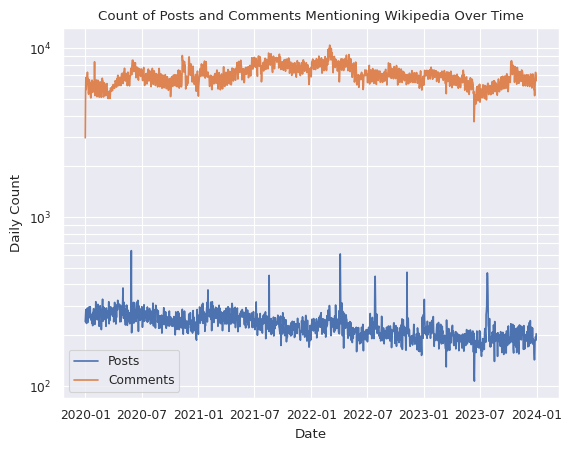

In [7]:
sns.lineplot(data=posts.groupby('created_date').count()['id'], label='Posts')
sns.lineplot(data=comments.groupby('created_date').count()['id'], label='Comments')
plt.yscale('log')
plt.yticks([10**2, 2*10**2, 3*10**2, 4*10**2, 5*10**2,
            6*10**2, 7*10**2, 8*10**2, 9*10**2,
            10**3, 2*10**3, 3*10**3, 4*10**3, 5*10**3,
            6*10**3, 7*10**3, 8*10**3, 9*10**3, 10**4]),
plt.ylabel('Daily Count')
plt.xlabel('Date')
plt.title('Count of Posts and Comments Mentioning Wikipedia Over Time')
plt.savefig('figures/posts_comments_over_time.png')
plt.savefig('figures/posts_comments_over_time.pdf')
plt.legend()

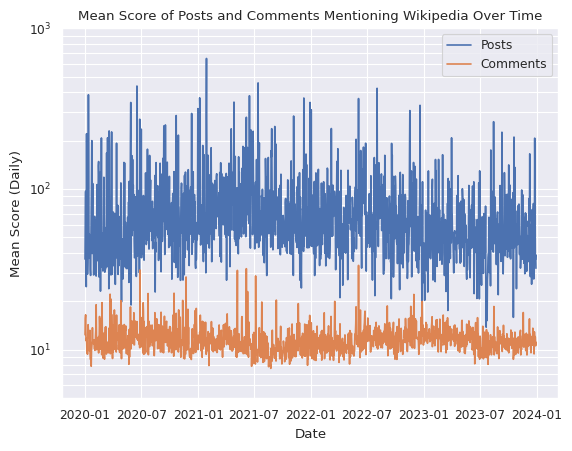

In [8]:
sns.lineplot(data=posts.groupby('created_date')['score'].mean(), label='Posts')
sns.lineplot(data=comments.groupby('created_date')['score'].mean(), label='Comments')
plt.yscale('log')
plt.yticks([5*10**0,
            6*10**0, 7*10**0, 8*10**0, 9*10**0,
            10**1, 2*10**1, 3*10**1, 4*10**1, 5*10**1,
            6*10**1, 7*10**1, 8*10**1, 9*10**1, 10**2,
            2*10**2, 3*10**2, 4*10**2, 5*10**2, 6*10**2, 7*10**2, 8*10**2, 9*10**2, 10**3])
plt.ylabel('Mean Score (Daily)')
plt.xlabel('Date')
plt.title('Mean Score of Posts and Comments Mentioning Wikipedia Over Time')
plt.savefig('figures/posts_comments_score_over_time.png')
plt.savefig('figures/posts_comments_score_over_time.pdf')
plt.legend()

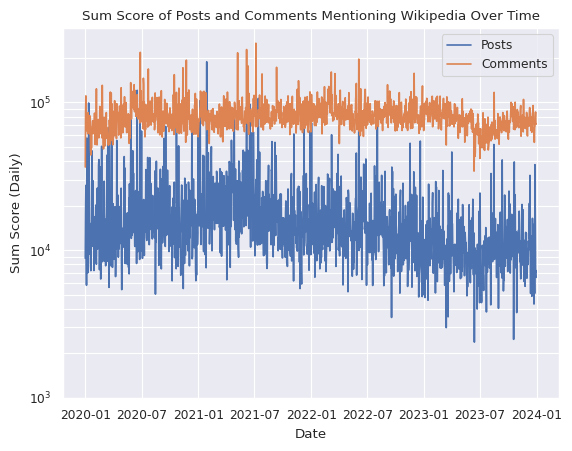

In [9]:
posts.groupby('created_date')['score'].sum().plot(label='Posts')
comments.groupby('created_date')['score'].sum().plot(label='Comments')
plt.yscale('log')
plt.yticks([n*10**e for e in range(3, 6) for n in range(1, 10)][:-7])
plt.ylabel('Sum Score (Daily)')
plt.xlabel('Date')
plt.title('Sum Score of Posts and Comments Mentioning Wikipedia Over Time')
plt.savefig('figures/posts_comments_sum_score_over_time.png')
plt.savefig('figures/posts_comments_sum_score_over_time.pdf')
plt.legend()

74.70713045963495 811.5214564744397 1.0 6.0 23.0


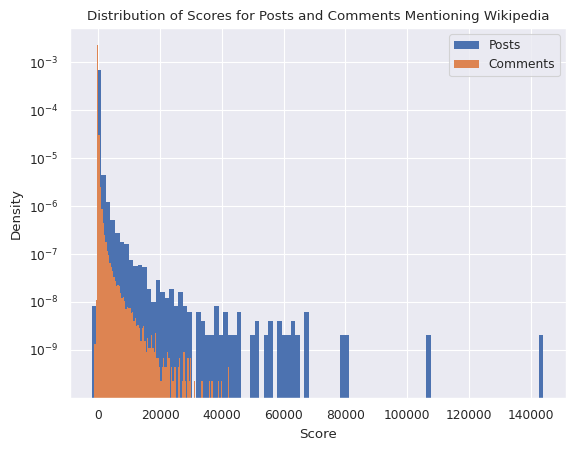

In [ ]:
plt.hist(posts['score'], label='Posts', log=True, bins=100,  density=True, lw=0)
plt.hist(comments['score'], label='Comments', log=True, bins=100, density=True, lw=0)
plt.legend()
# plt.ylim(10**-5, 10**-3)
plt.xlabel('Score')
plt.ylabel('Density')
print(posts['score'].mean(), posts['score'].std(), posts['score'].quantile(.25),
      posts['score'].median(), posts['score'].quantile(.75))

# Add text for median to the legend
median_posts = posts['score'].median()
median_comments = comments['score'].median()
plt.axvline(median_posts, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(median_comments, color='orange', linestyle='dashed', linewidth=1)
plt.legend(['Posts', 'Comments', f'Median Posts: {median_posts}', f'Median Comments: {median_comments}'])
plt.title('Distribution of Scores for Posts and Comments Mentioning Wikipedia')
plt.savefig('figures/posts_comments_score_distribution.png')
plt.savefig('figures/posts_comments_score_distribution.pdf')
plt.show()

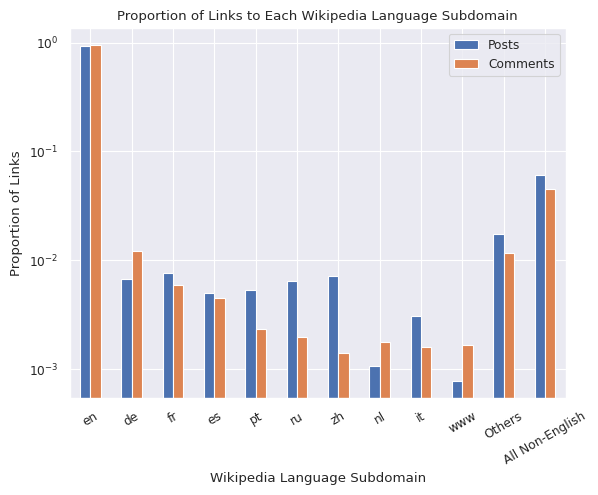

In [11]:
vc = clla_v['lang'].value_counts()
vp = plla_v['lang'].value_counts()

langcounts = pd.concat([vc, vp], axis=1)
langcounts.columns = ['Comments', 'Posts']
langcounts['sum'] = langcounts.sum(axis=1)

langcounts['Comments'] = langcounts['Comments'] / langcounts['Comments'].sum()
langcounts['Posts'] = langcounts['Posts'] / langcounts['Posts'].sum()
langcounts['sum'] = langcounts['sum'] / langcounts['sum'].sum()
lcp = langcounts.sort_values('sum', ascending=False).iloc[:10]
lcp.loc['Others'] = langcounts.iloc[10:].sum()
lcp.loc['All Non-English'] = langcounts.iloc[1:].sum()

lcp[['Posts', 'Comments']].plot(kind='bar')

plt.yscale('log')
plt.ylabel('Proportion of Links')
plt.xlabel('Wikipedia Language Subdomain')
plt.xticks(rotation=30)
plt.title('Proportion of Links to Each Wikipedia Language Subdomain')
plt.savefig('figures/lang_proportion.png')
plt.savefig('figures/lang_proportion.pdf')
plt.show()


In [12]:
prop_links = (plla_v['lang'].value_counts()/plla_v['lang'].value_counts().sum()).iloc[0]
prop_posts = (plla_v.drop_duplicates(subset=['id'])['language_code'].str[:2].value_counts()/plla_v.drop_duplicates(subset=['id'])['language_code'].str[:2].value_counts().sum()).iloc[0]

print(f"Proportion of posts in English: {prop_links:.2%}")
print(f"Proportion of links from posts to English Wikipedia: {prop_posts:.2%}")

Proportion of posts in English: 93.91%
Proportion of links from posts to English Wikipedia: 95.79%


In [33]:
nonen_links_from_en = (lang_counts.loc[['en', 'en-au', 'en-ca', 'en-gb', 'en-us']].sum().sum()
                       - lang_counts.loc[['en', 'en-au', 'en-ca', 'en-gb', 'en-us']]['en'].sum())
nonen_links = lang_counts.sum().sum() - lang_counts['en'].sum()

frac = nonen_links_from_en / nonen_links
print(f"Fraction of links from English Reddit to non-English Wikipedia: {frac:.2%}")

Fraction of links from English Reddit to non-English Wikipedia: 50.85%


In [13]:
# Group by language_code and lang, then count the occurrences
lang_counts = plla_v.groupby(['language_code', 'lang']).size().unstack(fill_value=0)

# Get the count of 'en' for each language_code
en_counts = lang_counts['en']

# Get the largest count for non-'en' languages for each language_code
non_en_counts = lang_counts.drop(columns='en').max(axis=1)

# Combine the results into a DataFrame
result = pd.DataFrame({'en_count': en_counts, 'max_non_en_count': non_en_counts})
result['total'] = lang_counts.sum(axis=1)
result['en_proportion'] = result['en_count'] / result['total']
result['max_non_en_proportion'] = result['max_non_en_count'] / result['total']
result = result.reset_index()

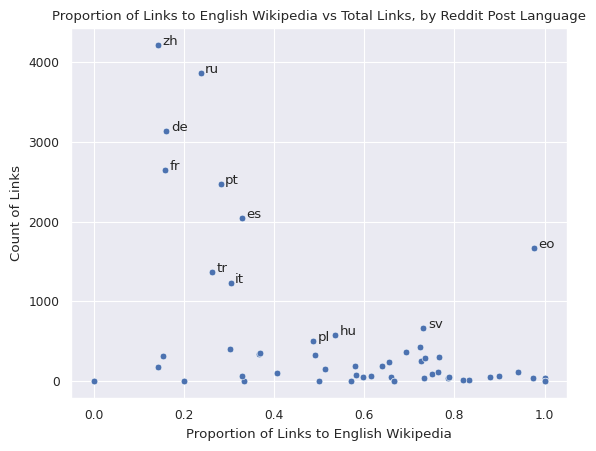

In [14]:
sns.scatterplot(data = result[~result['language_code'].str.contains('en')], x='en_proportion', y='total')
for i in range(len(result)):
    if (result.loc[i, 'total'] > 500)&('en' not in result.loc[i, 'language_code']):
        plt.text(result.loc[i, 'en_proportion']+0.01, result.loc[i, 'total'], result.loc[i, 'language_code'])

plt.ylabel('Count of Links')
plt.xlabel('Proportion of Links to English Wikipedia')
plt.title('Proportion of Links to English Wikipedia vs Total Links, by Reddit Post Language')
plt.savefig('figures/en_proportion_vs_total.png')
plt.savefig('figures/en_proportion_vs_total.pdf')
plt.show()

Topics

In [21]:
l_topics_df = pd.read_hdf('data/topics_df.h5', key='df')

In [25]:
l_topics_df.dropna().sum().sort_values(ascending=False)

STEM.STEM*                                  281485.381398
Geography.Regions.Europe.Europe*            271847.354921
Culture.Media.Media*                        259301.103182
Culture.Biography.Biography*                254314.986644
Geography.Regions.Americas.North_America    183818.026405
                                                ...      
Geography.Regions.Africa.Western_Africa       3784.303139
Culture.Media.Radio                            3753.54075
STEM.Libraries_&_Information                  3627.561852
Geography.Regions.Asia.Central_Asia           3282.695947
Geography.Regions.Africa.Central_Africa       1947.806135
Length: 64, dtype: object

In [30]:
l_topics_df.dropna().idxmax(axis=1).value_counts().head(10)

STEM.STEM*                                     148727
Culture.Media.Media*                            98300
Culture.Biography.Biography*                    97185
Geography.Regions.Americas.North_America        77373
Culture.Sports                                  66229
Geography.Regions.Europe.Europe*                47768
History_and_Society.Politics_and_government     44588
History_and_Society.Military_and_warfare        44129
Culture.Philosophy_and_religion                 35997
STEM.Biology                                    33845
Name: count, dtype: int64

Page views

In [17]:
query = """
WITH plla_v AS (
    SELECT 
        linkarticles.lang,
        resolved_redirects.redirected_title,
        posts.created_at
    FROM postlinks
    LEFT JOIN linkarticles 
        ON postlinks.final_url = linkarticles.final_url
    LEFT JOIN posts 
        ON postlinks.id = posts.id
    LEFT JOIN resolved_redirects 
        ON linkarticles.lang = resolved_redirects.lang 
        AND linkarticles.raw_title = resolved_redirects.raw_title
    WHERE postlinks.final_valid = 1
),
input_data AS (
    SELECT DISTINCT
        plla_v.lang,
        plla_v.redirected_title AS title,
        DATE(plla_v.created_at) AS date
    FROM plla_v
)
SELECT
    i.lang,
    i.title,
    i.date,
    SUM(CASE WHEN pv.date BETWEEN DATE(i.date, '-7 days') AND DATE(i.date, '-1 day') THEN pv.pageviews ELSE 0 END) AS before_pageviews,
    SUM(CASE WHEN DATE(pv.date) = i.date THEN pv.pageviews ELSE 0 END) AS day_pageviews,
    SUM(CASE WHEN pv.date BETWEEN DATE(i.date, '+1 day') AND DATE(i.date, '+7 days') THEN pv.pageviews ELSE 0 END) AS after_pageviews
FROM input_data i
LEFT JOIN pageviews pv
ON i.lang = pv.lang AND i.title = pv.title
GROUP BY i.lang, i.title, i.date;
"""

# Execute the query and load the result into a pandas DataFrame
p_pvdf = pd.read_sql(query, conn)
p_pvdf.to_hdf('data/p_pvdf.h5', key='df')

/tmp/ipykernel_280920/2506334805.py:39: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['lang', 'title', 'date'], dtype='object')]

  p_pvdf.to_hdf('data/p_pvdf.h5', key='df')


In [71]:
query = """
WITH clla_v AS (
    SELECT 
        linkarticles.lang,
        resolved_redirects.redirected_title,
        comments.created_at
    FROM commentlinks
    LEFT JOIN linkarticles 
        ON commentlinks.final_url = linkarticles.final_url
    LEFT JOIN comments 
        ON commentlinks.id = comments.id
    LEFT JOIN resolved_redirects 
        ON linkarticles.lang = resolved_redirects.lang 
        AND linkarticles.raw_title = resolved_redirects.raw_title
    WHERE commentlinks.final_valid = 1
),
input_data AS (
    SELECT DISTINCT
        clla_v.lang,
        clla_v.redirected_title AS title,
        DATE(clla_v.created_at) AS date
    FROM clla_v
)
SELECT
    i.lang,
    i.title,
    i.date,
    SUM(CASE WHEN pv.date BETWEEN DATE(i.date, '-7 days') AND DATE(i.date, '-1 day') THEN pv.pageviews ELSE 0 END) AS before_pageviews,
    SUM(CASE WHEN DATE(pv.date) = i.date THEN pv.pageviews ELSE 0 END) AS day_pageviews,
    SUM(CASE WHEN pv.date BETWEEN DATE(i.date, '+1 day') AND DATE(i.date, '+7 days') THEN pv.pageviews ELSE 0 END) AS after_pageviews
FROM input_data i
LEFT JOIN pageviews pv
ON i.lang = pv.lang AND i.title = pv.title
GROUP BY i.lang, i.title, i.date;
"""

# Execute the query and load the result into a pandas DataFrame
c_pvdf = pd.read_sql(query, conn)
c_pvdf.to_hdf('data/c_pvdf.h5', key='df')

In [2]:
p_pvdf = pd.read_hdf('data/p_pvdf.h5', key='df')
c_pvdf = pd.read_hdf('data/c_pvdf.h5', key='df')

In [3]:
p_pvdf_noinf = p_pvdf.copy()

p_pvdf_noinf['before_mean'] = p_pvdf_noinf['before_pageviews'] / 7
p_pvdf_noinf['after_mean'] = p_pvdf_noinf['after_pageviews'] / 7

p_pvdf_noinf['delta_day'] = p_pvdf_noinf['day_pageviews'] - p_pvdf_noinf['before_mean']
p_pvdf_noinf['delta_after'] = p_pvdf_noinf['after_mean'] - p_pvdf_noinf['before_mean']

p_pvdf_noinf['excess_day'] = (p_pvdf_noinf['day_pageviews'] - p_pvdf_noinf['before_mean'])/p_pvdf_noinf['before_mean']
p_pvdf_noinf['excess_after'] = (p_pvdf_noinf['after_mean'] - p_pvdf_noinf['before_mean'])/p_pvdf_noinf['before_mean']
p_pvdf_noinf['excess_day_log'] = np.log10(p_pvdf_noinf['excess_day'])
p_pvdf_noinf['excess_after_log'] = np.log10(p_pvdf_noinf['excess_after'])

p_pvdf_noinf['frac_day'] = p_pvdf_noinf['day_pageviews'] / p_pvdf_noinf['before_mean']
p_pvdf_noinf['frac_after'] = p_pvdf_noinf['after_mean'] / p_pvdf_noinf['before_mean']
p_pvdf_noinf['frac_day_log'] = np.log10(p_pvdf_noinf['frac_day'])
p_pvdf_noinf['frac_after_log'] = np.log10(p_pvdf_noinf['frac_after'])

p_pvdf_noinf = p_pvdf_noinf.replace(np.inf, np.nan)
p_pvdf_noinf = p_pvdf_noinf.replace(-np.inf, np.nan)


/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patric

In [4]:
c_pvdf_noinf = c_pvdf.copy()

c_pvdf_noinf['before_mean'] = c_pvdf_noinf['before_pageviews'] / 7
c_pvdf_noinf['after_mean'] = c_pvdf_noinf['after_pageviews'] / 7

c_pvdf_noinf['delta_day'] = c_pvdf_noinf['day_pageviews'] - c_pvdf_noinf['before_mean']
c_pvdf_noinf['delta_after'] = c_pvdf_noinf['after_mean'] - c_pvdf_noinf['before_mean']
c_pvdf_noinf['delta_day_log'] = np.log10(c_pvdf_noinf['delta_day'])
c_pvdf_noinf['delta_after_log'] = np.log10(c_pvdf_noinf['delta_after'])

c_pvdf_noinf['excess_day'] = (c_pvdf_noinf['day_pageviews'] - c_pvdf_noinf['before_mean'])/c_pvdf_noinf['before_mean']
c_pvdf_noinf['excess_after'] = (c_pvdf_noinf['after_mean'] - c_pvdf_noinf['before_mean'])/c_pvdf_noinf['before_mean']
c_pvdf_noinf['excess_day_log'] = np.log10(c_pvdf_noinf['excess_day'])
c_pvdf_noinf['excess_after_log'] = np.log10(c_pvdf_noinf['excess_after'])

c_pvdf_noinf['frac_day'] = c_pvdf_noinf['day_pageviews'] / c_pvdf_noinf['before_mean']
c_pvdf_noinf['frac_after'] = c_pvdf_noinf['after_mean'] / c_pvdf_noinf['before_mean']
c_pvdf_noinf['frac_day_log'] = np.log10(c_pvdf_noinf['frac_day'])
c_pvdf_noinf['frac_after_log'] = np.log10(c_pvdf_noinf['frac_after'])

c_pvdf_noinf = c_pvdf_noinf.replace(np.inf, np.nan)
c_pvdf_noinf = c_pvdf_noinf.replace(-np.inf, np.nan)

/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patrick/Documents/R4R/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/patric

In [5]:
p_pvdf_noinf['type'] = 'Posts'
c_pvdf_noinf['type'] = 'Comments'

pvdf_noinf = pd.concat([p_pvdf_noinf, c_pvdf_noinf], ignore_index=True)
pvdf_noinf = pvdf_noinf[['frac_day_log', 'frac_after_log', 'type']].dropna().melt(id_vars='type').rename(columns={'variable': 'period', 'value': 'logfrac'})


In [6]:
for period in ['frac_day_log', 'frac_after_log']:
    for t in ['Posts', 'Comments']:
        subset = pvdf_noinf[(pvdf_noinf['period'] == period) & (pvdf_noinf['type'] == t)]
        median = 10**subset['logfrac'].median()
        mean = 10**subset['logfrac'].mean()
        print(f"{t} {period} median: {median:.2f}")
        print(f"{t} {period} mean: {mean:.2f}")

Posts frac_day_log median: 1.23
Posts frac_day_log mean: 1.45
Comments frac_day_log median: 1.25
Comments frac_day_log mean: 1.45
Posts frac_after_log median: 1.01
Posts frac_after_log mean: 1.06
Comments frac_after_log median: 1.01
Comments frac_after_log mean: 1.05


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_522638/1971648415.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}$ Value Relative to Week Before Post/Comment')


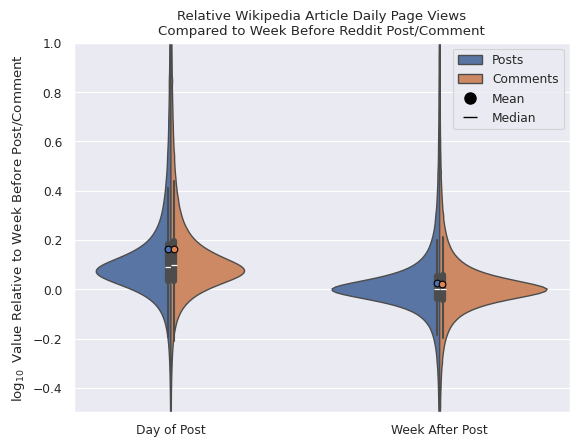

In [8]:
import matplotlib.lines as mlines

sns.violinplot(hue='type', y='logfrac', x='period', data=pvdf_noinf, split=True, gridsize=1000)
plt.ylim(-0.5, 1)
plt.title('Relative Wikipedia Article Daily Page Views\nCompared to Week Before Reddit Post/Comment')
plt.ylabel('$\log_{10}$ Value Relative to Week Before Post/Comment')
plt.xlabel('')
plt.xticks([0, 1], ['Day of Post', 'Week After Post'])

# Calculate and add median and mean text
for period in ['frac_day_log', 'frac_after_log']:
    for t in ['Posts', 'Comments']:
        subset = pvdf_noinf[(pvdf_noinf['period'] == period) & (pvdf_noinf['type'] == t)]
        median = subset['logfrac'].median()
        mean = subset['logfrac'].mean()
        # add marker at mean
        if period == 'frac_day_log':
            x = 0
        else:
            x = 1
        x += (-1)**(t == 'Posts') * 0.01
        plt.scatter(x, mean, color=sns.color_palette()[t=='Comments'], zorder=5, edgecolors='black')

# Get existing legend handles and labels from the violinplot
handles, labels = plt.gca().get_legend_handles_labels()

# Create custom legend handles for median and mean
mean_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Mean')
median_marker = mlines.Line2D([], [], color='black', marker='_', linestyle='None', markersize=10, label='Median')

# Add custom handles for median and mean
handles.extend([mean_marker, median_marker])
labels.extend(['Mean', 'Median'])

# Add the combined legend to the plot
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.savefig('figures/pageview_change_violin.png')
plt.savefig('figures/pageview_change_violin.pdf')
plt.show()

Revisions

In [40]:
query = """
WITH plla_v AS (
    SELECT 
        linkarticles.lang,
        resolved_redirects.redirected_title,
        posts.created_at
    FROM postlinks
    LEFT JOIN linkarticles 
        ON postlinks.final_url = linkarticles.final_url
    LEFT JOIN posts 
        ON postlinks.id = posts.id
    LEFT JOIN resolved_redirects 
        ON linkarticles.lang = resolved_redirects.lang 
        AND linkarticles.raw_title = resolved_redirects.raw_title
    WHERE postlinks.final_valid = 1
),
input_data AS (
    SELECT DISTINCT
        plla_v.lang,
        plla_v.redirected_title AS title,
        DATE(plla_v.created_at) AS date
    FROM plla_v
)
SELECT
    i.lang,
    i.title,
    i.date,
    COUNT(CASE WHEN rv.timestamp BETWEEN DATE(i.date, '-7 days') AND DATE(i.date) THEN 1 ELSE NULL END) AS before_edits,
    COUNT(CASE WHEN DATE(rv.timestamp) = i.date THEN 1 ELSE NULL END) AS day_edits,
    COUNT(CASE WHEN rv.timestamp BETWEEN DATE(i.date, '+1 day') AND DATE(i.date, '+8 days') THEN 1 ELSE NULL END) AS after_edits
FROM input_data i
LEFT JOIN revisions rv
ON i.lang = rv.lang AND i.title = rv.title
GROUP BY i.lang, i.title, i.date;
"""

# Execute the query and load the result into a pandas DataFrame
p_rvdf = pd.read_sql(query, conn)
p_rvdf.to_hdf('data/p_rvdf.h5', key='df')

/tmp/ipykernel_280920/2480730500.py:39: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['lang', 'title', 'date'], dtype='object')]

  p_rvdf.to_hdf('data/p_rvdf.h5', key='df')


In [19]:
query = """
WITH clla_v AS (
    SELECT 
        linkarticles.lang,
        resolved_redirects.redirected_title,
        comments.created_at
    FROM commentlinks
    LEFT JOIN linkarticles 
        ON commentlinks.final_url = linkarticles.final_url
    LEFT JOIN comments 
        ON commentlinks.id = comments.id
    LEFT JOIN resolved_redirects 
        ON linkarticles.lang = resolved_redirects.lang 
        AND linkarticles.raw_title = resolved_redirects.raw_title
    WHERE commentlinks.final_valid = 1
),
input_data AS (
    SELECT DISTINCT
        clla_v.lang,
        clla_v.redirected_title AS title,
        DATE(clla_v.created_at) AS date
    FROM clla_v
)
SELECT
    i.lang,
    i.title,
    i.date,
    COUNT(CASE WHEN rv.timestamp BETWEEN DATE(i.date, '-7 days') AND DATE(i.date) THEN 1 ELSE NULL END) AS before_edits,
    COUNT(CASE WHEN DATE(rv.timestamp) = i.date THEN 1 ELSE NULL END) AS day_edits,
    COUNT(CASE WHEN rv.timestamp BETWEEN DATE(i.date, '+1 day') AND DATE(i.date, '+8 days') THEN 1 ELSE NULL END) AS after_edits
FROM input_data i
LEFT JOIN revisions rv
ON i.lang = rv.lang AND i.title = rv.title
GROUP BY i.lang, i.title, i.date;
"""

# Execute the query and load the result into a pandas DataFrame
c_rvdf = pd.read_sql(query, conn)
c_rvdf.to_hdf('data/c_rvdf.h5', key='df')

In [41]:
p_rvdf = pd.read_hdf('data/p_rvdf.h5', key='df')
c_rvdf = pd.read_hdf('data/c_rvdf.h5', key='df')

In [42]:
p_rvdf['before_edits_daily'] = p_rvdf['before_edits'] / 7
p_rvdf['day_diff'] = p_rvdf['day_edits'] - p_rvdf['before_edits_daily']
p_rvdf['after_edits_daily'] = p_rvdf['after_edits'] / 7
p_rvdf['after_diff'] = p_rvdf['after_edits_daily'] - p_rvdf['before_edits_daily']

c_rvdf['before_edits_daily'] = c_rvdf['before_edits'] / 7
c_rvdf['day_diff'] = c_rvdf['day_edits'] - c_rvdf['before_edits_daily']
c_rvdf['after_edits_daily'] = c_rvdf['after_edits'] / 7
c_rvdf['after_diff'] = c_rvdf['after_edits_daily'] - c_rvdf['before_edits_daily']

p_rvdf['type'] = 'Posts'
c_rvdf['type'] = 'Comments'
rvdf = pd.concat([p_rvdf, c_rvdf], ignore_index=True)
rvdf = rvdf[['day_diff', 'after_diff', 'type']][(~rvdf['lang'].isnull()) &
                                                (rvdf[['before_edits', 'day_edits', 'after_edits']].sum(axis=1) > 0)]
rvdf = rvdf[['day_diff', 'after_diff', 'type']].dropna().melt(id_vars='type').rename(columns={'variable': 'period', 'value': 'diff'})

rvdf

,type,period,diff
0,Posts,day_diff,-0.571429
1,Posts,day_diff,-0.142857
2,Posts,day_diff,-0.142857
3,Posts,day_diff,4.000000
4,Posts,day_diff,-0.142857
...,...,...,...
8185389,Comments,after_diff,0.285714
8185390,Comments,after_diff,1.428571
8185391,Comments,after_diff,-27.285714
8185392,Comments,after_diff,-0.571429


In [43]:
for period in ['day_diff', 'after_diff']:
    for t in ['Posts', 'Comments']:
        subset = rvdf[(rvdf['period'] == period) & (rvdf['type'] == t)]
        median = subset['diff'].median()
        mean = subset['diff'].mean()
        print(f'{t} {period} median: {median}, mean: {mean}')


Posts day_diff median: -0.14285714285714285, mean: 0.46179202876835485
Comments day_diff median: -0.14285714285714285, mean: 0.12653885053375327
Posts after_diff median: 0.0, mean: -0.03116905355871065
Comments after_diff median: 0.0, mean: -0.021888857885643896
